### GLM Model Selection

In [1]:
import matplotlib
import json
import warnings

warnings.simplefilter('ignore')
%matplotlib inline
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"

s = json.load(open(root))
matplotlib.rcParams.update(s)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

In [2]:
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_powell
from scipy import integrate

import pymc3 as pm
import theano as thno
import theano.tensor as T

from IPython.html.widgets import interactive, fixed
from IPython.core.pylabtools import figsize

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

In [3]:
    def generate_data(n = 20, p = 0, a = 1, b = 1, c = 0, latent_sigma_y = 20 ):
    
        """
        Create a toy dataset based on a very simple model we might
        imagine is a noisy physical process:
            1. random x values within a range
            2. latent error aka inherent noise in y
            3. optionally create labelled outliers with a larger noise
        
        Model form : y ~ a + bx + cx^2 + e
    
        NOTE: latent_sigma_y is used to create a normally distributed,
        'latent error' aka 'inherent noise' in the 'physical process'
        genrating these values, rather than experimental measurement error
        Please don't use the returned 'latent_error' value in inferential models, 
        it's returned in e dataframe for interest only.
        """
        df = pd.DataFrame({'x':rndst.choice(np.arange(100), n, replace = False)})
    
        ## Create linear or quadratic model
        df['y'] = a + b*df['x'] + c*df['x']**2
    
        ##create letent noise and marked outliers
        df['latent_error'] = rndst.normal(0, latent_sigma_y, n)
        df['outlier_error'] = rndst.normal(0, latent_sigma_y*10, n)
        df['outlier'] = rndst.binomial(1, p, n)
    
        ## add noise, with extreme noise for marked ouliers
        df['y'] += ((1 - df['outlier']) * df['latent_error'])
        df['y'] += (df['outlier'] * df['outlier_error'])
    
        ## round
        for col in ['y', 'latent_error', 'outlier_error', 'x']:
            df[col] = np.round(df[col], 3)
        
        ## add label
        df['source'] = 'linear' if c == 0 else 'quadratic'
    
        ##create simple linspace for plotting true model
        plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1,
                           df['x'].max() - np.ptp(df['x'])*.1, 100)
        ploty = a + b*plotx + c*plotx**2
        dfp = pd.DataFrame({'x':plotx, 'y':ploty})
    
        return df, dfp


    def interact_dataset(n = 20, p = 0, a = -30, b = 5, c = 0, latent_sigma_y = 20):
        """
        Convenience function
        Interactively generate dataset and plot
        """
    
        df, dfp = generate_data(n, p, a, b, c, latent_sigma_y)
    
        g = sns.FacetGrid(df, size = 8, hue = 'outlier', hue_order = [True, False],
                     palette = sns.color_palette('Set1'), legend_out = False)
    
        _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker = "o", ms = 10,
             mec = 'w', mew = 2, ls = '', elinewidth = 0.7).add_legend()
        _ = plt.plot(dfp['x'], dfp['y'], '--', alpha = 0.8)
    
        plt.subplots_adjust(top = 0.92)
    
        _ = g.fig.suptitle('sketch of data Generation ({})'.format(df['source'][0]),
                      fontsize = 16)
    
    def plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad):
        """
        Convenience function:
        plot the two generated datasets in facets with generative model
        """
        
        df = pd.concat((df_lin, df_quad), axis = 0)
        dfp_lin, dfp_quad
        
        g = sns.FacetGrid(col = "source", hue = 'source', data = df, size = 6, sharey = False,
                         legend_out = False)
        
        _ = g.map(plt.scatter, 'x', 'y', alpha = 0.7, s = 100, lw = 2, edgecolor = "w")
        
        _ = g.axes[0][0].plot(dfp_lin['x'], dfp_lin['y'], '--', alpha = 0.6)
        _ = g.axes[0][1].plot(dfp_quad['x'], dfp_quad['y'], '--', alpha = 0.6)
        
        
    
    def plot_trace(traces, retain = 1000):
        """
        Convenience function : 
        plot trace with overlaid means and values
        """
        
        ax = pm.traceplot(traces[-retain:], figsize(12, len(traces.varnames)*1.5),
                         lines = {k : v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})
        
        for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
            ax[i, 0].annotate('{:.2f}'.format(mn), xy = (mn, 0), xycoords = 'data',xytext = (5, 10),
                             textcoords = 'offset points', rotation = 90, va = 'bottom', 
                             fontsize = 'large', color = "#AA0022")
            
    
    
    def create_poly_modelspec(k=1):
        """
        Convenience function:
        create a polynomial modelspec string for pasty
        """
        return ('y ~ 1 + x' + ' '.join([' + np.power(x, {})'.format(j) 
                                       for j in np.arange(2, k+1)])).strip()
    
    
    
    def run_models(df, upper_order = 5):
        """
        Convenience function:
        Fit a range of pymc3 models of increasing polynomial complexity.
        Suggest limit to max order 5 since calculation time exponential
        """
        
        models, traces = OrderedDict(), OrderedDict()
        
        for k in np.arange(1, upper_order + 1):
            nm = 'k{}'.format(k)
            fml = create_poly_modelspec(k)
            
            with pm.Model() as models[nm]:
                
                print("\nRunning: {}".format(nm))
                pm.glm.glm(fml, df, family = pm.glm.families.Normal())
                
                # for speed we would use Metropolis sampling here
                traces[nm] = pm.sample(5000, pm.Metropolis())[1000::5]
            
        return models, traces
    
    
    def plot_posterior_cr(models, traces, rawdata, xlims,
                      datamodelnm='linear', modelnm='k1'):
        '''
        Convenience function:
        Plot posterior predictions with credible regions shown as filled areas.
        '''

        ## Get traces and calc posterior prediction for npoints in x
        npoints = 100
        mdl = models[modelnm]
        trc = pm.trace_to_dataframe(traces[modelnm][-1000:])
        trc = trc[[str(v) for v in mdl.cont_vars[:-1]]]

        ordr = int(modelnm[-1:])
        x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
        pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
        X = x ** pwrs
        cr = np.dot(X,trc.T)

        ## Calculate credible regions and plot over the datapoints
        dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
        dfp['x'] = x

        pal = sns.color_palette('Greens')
        f, ax1d = plt.subplots(1,1, figsize=(12.5,5))
        f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
                        datamodelnm, modelnm), fontsize=16)
        plt.subplots_adjust(top=0.95)

        ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
        ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                      ,color=pal[4], label='CR 50%')
        ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[5], label='Median')
        _ = plt.legend()
        _ = ax1d.set_xlim(xlims)
        _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
                   ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)

    

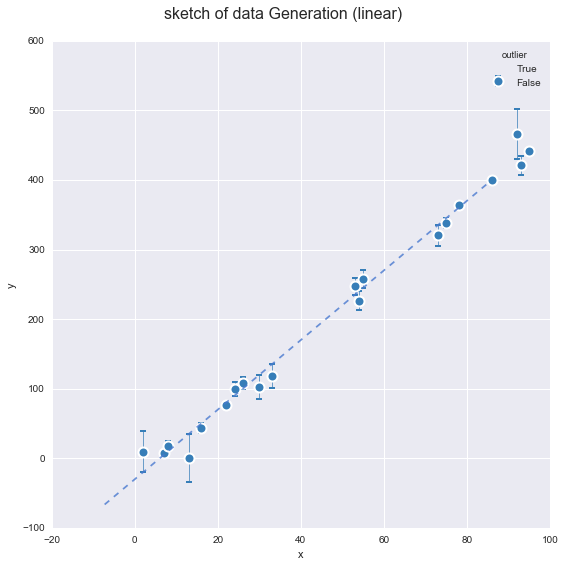

In [4]:
interactive(interact_dataset, n=[5,50,5], p=[0,.5,.05], a=[-50,50]
            ,b=[-10,10], c=[-3,3], latent_sigma_y=[0,1000,50])

In [5]:
n = 12
df_lin, dfp_lin = generate_data(n = n, p = 0, a = -30, b = 5, c = 0, latent_sigma_y = 40)
df_quad, dfp_quad = generate_data(n = n, p = 0, a = -200, b = 2, c = 3, latent_sigma_y = 500)

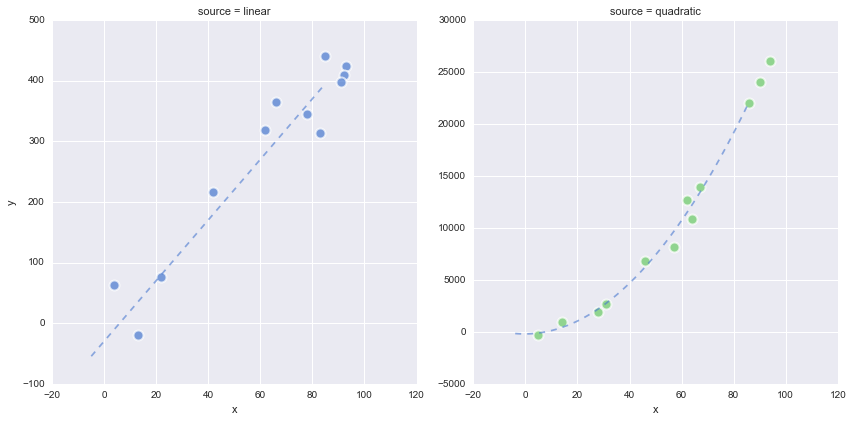

In [6]:
plot_datasets(df_lin, df_quad, dfp_lin, dfp_quad)

In [7]:
# We now have two datasets to play with : next -> Standardize
dfs_lin = df_lin.copy()
dfs_lin['x'] = (df_lin['x'] - df_lin['x'].mean()) / df_lin['x'].std()

dfs_quad = df_quad.copy()
dfs_quad['x'] = (df_quad['x'] - df_quad['x'].mean()) / df_quad['x'].std()

In [8]:
# Create range for later ylim and xlim

dfs_lin_xlims = (dfs_lin['x'].min() - np.ptp(dfs_lin['x'])/10,
                dfs_lin['x'].max() - np.ptp(dfs_lin['x'])/10) 

dfs_lin_ylims = (dfs_lin['y'].min() - np.ptp(dfs_lin['y'])/10,
                dfs_lin['y'].max() - np.ptp(dfs_lin['y'])/10)

dfs_quad_ylims = (dfs_quad['y'].min() - np.ptp(dfs_quad['y'])/10,
                 dfs_quad['y'].max() - np.ptp(dfs_quad['y'])/10)

In [9]:
with pm.Model() as OLS_model:
    
    ## define Normal priors to give Ridge regression
    b0 = pm.Normal("b0", mu = 0, sd = 100)
    b1 = pm.Normal("b1", mu = 0, sd = 100)
    
    ## add HalfCauchy noises
    sigma_y = pm.HalfCauchy("sigma_y", beta = 10)
    
    ##linear model
    yest = b0 + b1 * dfs_lin['x']
    
    ##Likelihood
    likelihood = pm.Normal("obs", mu = yest, sd = sigma_y, observed = dfs_lin['y'])
    
    #Sampling
    trace_ols = pm.sample(2000)
    

100%|██████████| 2000/2000 [00:04<00:00, 448.20it/s]


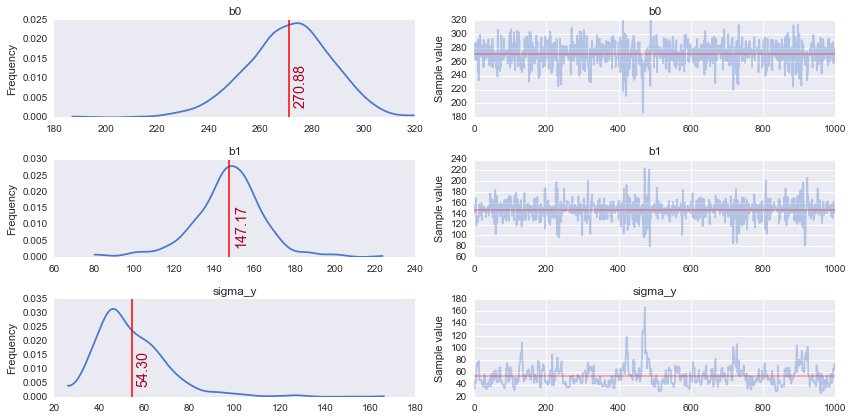

In [10]:
plot_trace(trace_ols, retain = 1000)

This simple OLS manages to make fairly good guesses on the model parameters - the data has been generated fairly simply after all - but it does appear to have been fooled slightly by the inherent noise.

Here’s the same OLS model as above, defined using glm :

In [11]:
with pm.Model() as mdl_glm_ols:
    
    pm.glm.glm('y ~ 1 + x', dfs_lin, family =pm.glm.families.Normal())
    
    trace_glm_ols = pm.sample(2000)

100%|██████████| 2000/2000 [00:05<00:00, 343.95it/s]


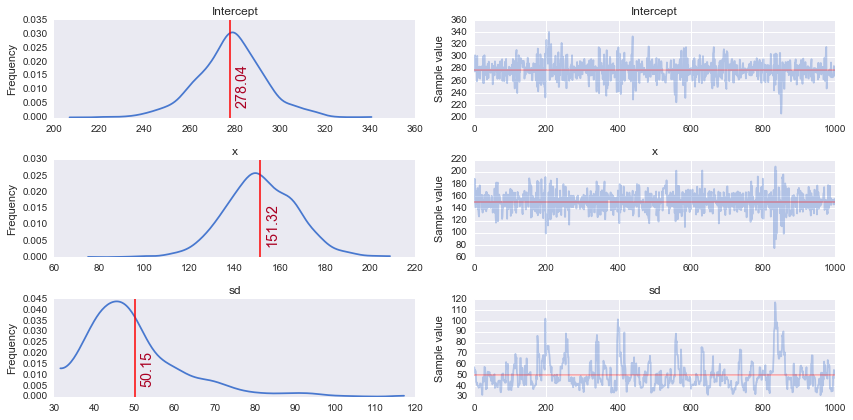

In [12]:
plot_trace(trace_glm_ols, retain = 1000)

### Create and run polynomial models

In [13]:
models_lin, traces_lin = run_models(dfs_lin, 5)


Running: k1


100%|██████████| 5000/5000 [00:01<00:00, 3195.81it/s]



Running: k2


100%|██████████| 5000/5000 [00:02<00:00, 2441.53it/s]



Running: k3


100%|██████████| 5000/5000 [00:02<00:00, 1989.06it/s]



Running: k4


100%|██████████| 5000/5000 [00:02<00:00, 1676.52it/s]



Running: k5


100%|██████████| 5000/5000 [00:03<00:00, 1285.28it/s]


In [14]:
models_quad, traces_quad = run_models(dfs_quad, 5)


Running: k1


100%|██████████| 5000/5000 [00:01<00:00, 2831.46it/s]



Running: k2


100%|██████████| 5000/5000 [00:02<00:00, 2399.19it/s]



Running: k3


100%|██████████| 5000/5000 [00:02<00:00, 1960.38it/s]



Running: k4


100%|██████████| 5000/5000 [00:03<00:00, 1643.81it/s]



Running: k5


100%|██████████| 5000/5000 [00:03<00:00, 1422.68it/s]


### View Posterior predictive fit

Comparing the likelihood is a bad way to compare models

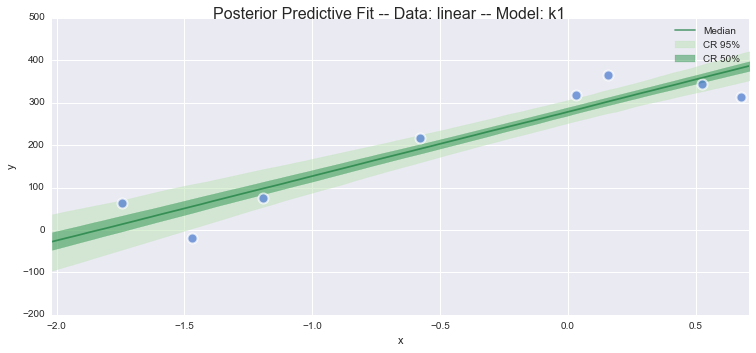

In [15]:
interactive(plot_posterior_cr, models = fixed(models_lin), traces = fixed(traces_lin),
           rawdata = fixed(dfs_lin), xlims=fixed(dfs_lin_xlims), datamodelnm=fixed('linear'),
           modelnm = ['k1','k2','k3','k4','k5'])

### Compare Deviance Information Criterion [DIC]

The deviance Information Criterion (DIC) is a faitly unsophisticated method for comparing the deviance
of likelihood across the sample traces of a model run.

In [16]:
# Let's first compute manually the DIC for the model_lin['k1']

dftrc_lin = pm.trace_to_dataframe(traces_lin['k1'], hide_transformed_vars = False )
trc_lin_logp = dftrc_lin.apply(lambda x : models_lin['k1'].logp(x.to_dict()), axis = 1)
mean_deviance = -2 * trc_lin_logp.mean(0)

deviance_at_mean = -2 * models_lin['k1'].logp(dftrc_lin.mean(0).to_dict())

dick1 = 2 * mean_deviance - deviance_at_mean
dick1

193.16143110831601

In [17]:
# Compute the DIC of models_lin['k1'] using pm.stats.dic
pm.stats.dic(trace = traces_lin['k1'], model = models_lin['k1'])

193.16143110831641

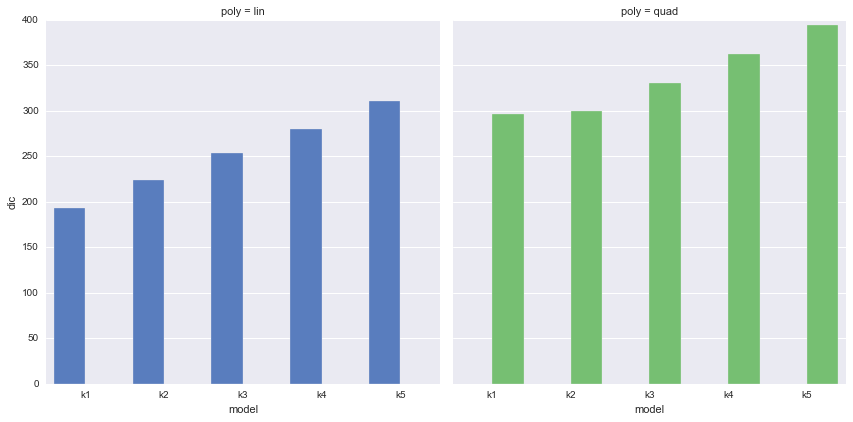

In [18]:
## Create a pandas dataframe for the dic's
dfdic = pd.DataFrame(index = ['k1', 'k2', 'k3', 'k4', 'k5'], columns = ['lin', 'quad'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(trace = traces_lin[nm], model = models_lin[nm])
    dfdic.loc[nm, 'quad'] = pm.stats.dic(trace = traces_quad[nm], model = models_quad[nm])
    
## Let's prepare the dataframe for plot : here i'm using seanborn with barplot but we can use simple matplotlib bar

_dfdic = pd.melt(dfdic.reset_index(), id_vars = 'model', var_name = 'poly', value_name = 'dic')

g = sns.factorplot(x = 'model', y = 'dic', hue = 'poly', col = 'poly', data = _dfdic, kind = 'bar', size = 6)

## Interpretation : we should take the model with yhe lower DIC
## as model as the model become complex, (more likeliy to overfit the data) the dic become more larger

### Compare Watanabe - Akaike Information Criterion [WAIC]
The is another simple option fot calculating a goodness of fit of model using numerical techniques

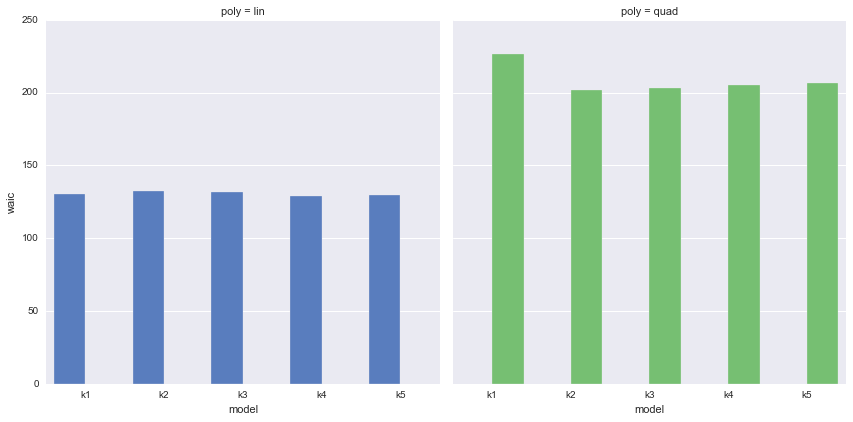

In [19]:
## Create a pandas DataFrame for the WAIC
dfwaic = pd.DataFrame(index = ['k1', 'k2', 'k3', 'k4', 'k5'], columns = ['lin', 'quad'])
dfwaic.index.name = 'model'

## filled the Datarame
for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.stats.waic(trace = traces_lin[nm], model = models_lin[nm])[0]
    dfwaic.loc[nm, 'quad'] = pm.stats.waic(trace = traces_quad[nm], model = models_quad[nm])[0]
    

## Let's prepare the dataframe for plot : here i'm using seanborn with barplot but we can use simple matplotlib bar
_dfwaic = pd.melt(dfwaic.reset_index(), id_vars = 'model', var_name = 'poly', value_name = 'waic')

g = sns.factorplot(x = 'model', y = 'waic', col = 'poly', hue = 'poly', data = _dfwaic, kind = 'bar', size = 6)


## We should prefer the model(s) with the lower WAIC
## Quadratic generated data : thewaic is certainly wrong for the model k1
## for theseparticular modelsand data, iwould prefer to use the DIC score in orderto choses models

### TODO : K-Fold cross Validation // Leave-One-Out(LOO)
http://www.stat.columbia.edu/~gelman/research/unpublished/waic_stan.pdf